# How to handle tool calling errors

LLMs aren't perfect at calling tools. The model may try to call a tool that doesn't exist or fail to return arguments that match the requested schema. Strategies like keeping schemas simple, reducing the number of tools you pass at once, and having good names and descriptions can help mitigate this risk, but aren't foolproof.

This guide covers some ways to build error handling into your graphs to mitigate these failure modes.

<div class="admonition tip">
    <p class="admonition-title">Compatibility</p>
    <p>
        This guide requires <code>@langchain/langgraph>=0.0.28</code>, <code>@langchain/anthropic>=0.2.6</code>, and <code>@langchain/core>=0.2.17</code>. For help upgrading, see <a href="/langgraphjs/how-tos/manage-ecosystem-dependencies/">this guide</a>.
    </p>
</div>

## Using the prebuilt `ToolNode`

To start, define a mock weather tool that has some hidden restrictions on input queries. The intent here is to simulate a real-world case where a model fails to call a tool correctly:

```bash
$ npm install @langchain/anthropic
```

In [1]:
import { z } from "zod";
import { tool } from "@langchain/core/tools";

const getWeather = tool(async ({ location }) => {
  if (location === "SAN FRANCISCO") {
    return "It's 60 degrees and foggy";
  } else if (location.toLowerCase() === "san francisco") {
    throw new Error("Input queries must be all capitals");
  } else {
    throw new Error("Invalid input.");
  }
}, {
  name: "get_weather",
  description: "Call to get the current weather",
  schema: z.object({
    location: z.string(),
  }),
});

Next, set up a graph implementation of the [ReAct agent](/langgraphjs/concepts/). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll use the prebuilt [`ToolNode`](/langgraphjs/reference/classes/langgraph_prebuilt.ToolNode.html) to execute called tools, and a small, fast model powered by Anthropic:

In [2]:
import { StateGraph, Annotation, messagesStateReducer } from "@langchain/langgraph";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { ChatAnthropic } from "@langchain/anthropic";
import { BaseMessage, isAIMessage } from "@langchain/core/messages";

const GraphState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: messagesStateReducer,
  }),
});

const toolNode = new ToolNode<typeof GraphState.State>([getWeather]);

const modelWithTools = new ChatAnthropic({
  model: "claude-3-haiku-20240307",
  temperature: 0,
}).bindTools([getWeather]);

const shouldContinue = async (state: typeof GraphState.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1];
  if (isAIMessage(lastMessage) && lastMessage.tool_calls?.length) {
    return "tools";
  }
  return "__end__";
}

const callModel = async (state: typeof GraphState.State) => {
  const { messages } = state;
  const response = await modelWithTools.invoke(messages);
  return { messages: [response] };
}

const app = new StateGraph(GraphState)
  .addNode("agent", callModel)
  .addNode("tools", toolNode)
  .addEdge("__start__", "agent")
  .addEdge("tools", "agent")
  .addConditionalEdges("agent", shouldContinue, {
    // Explicitly list possible destinations so that
    // we can automatically draw the graph below.
    tools: "tools",
    __end__: "__end__",
  })
  .compile();

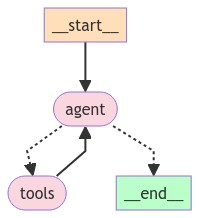

In [3]:
import * as tslab from "tslab";

const graph = app.getGraph();
const image = await graph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

When you try to call the tool, you can see that the model calls the tool with a bad input, causing the tool to throw an error. The prebuilt `ToolNode` that executes the tool has some built-in error handling that captures the error and passes it back to the model so that it can try again:

In [4]:
import { HumanMessage } from "@langchain/core/messages";

const response = await app.invoke({
  messages: [
    new HumanMessage("what is the weather in san francisco?"),
  ]
});

for (const message of response.messages) {
  // Anthropic returns tool calls in content as well as in `AIMessage.tool_calls`
  const content = JSON.stringify(message.content, null, 2);
  console.log(`${message._getType().toUpperCase()}: ${content}`);
}

HUMAN: "what is the weather in san francisco?"
AI: [
  {
    "type": "text",
    "text": "Okay, let's check the weather in San Francisco:"
  },
  {
    "type": "tool_use",
    "id": "toolu_01TiQFrXDi5x4p7oEEZ99T5p",
    "name": "get_weather",
    "input": {
      "location": "San Francisco"
    }
  }
]
TOOL: "Error: Input queries must be all capitals\n Please fix your mistakes."
AI: [
  {
    "type": "text",
    "text": "Apologies, let me try that again with the location in all capital letters:"
  },
  {
    "type": "tool_use",
    "id": "toolu_01B1LiK5i74E52EwfHL3S3XJ",
    "name": "get_weather",
    "input": {
      "location": "SAN FRANCISCO"
    }
  }
]
TOOL: "It's 60 degrees and foggy"
AI: "The weather in San Francisco is 60 degrees and foggy."


## Custom strategies

This is a fine default in many cases, but there are cases where custom fallbacks may be better.

For example, the below tool requires as input a list of elements of a specific length - tricky for a small model! We'll also intentionally avoid pluralizing `topic` to trick the model into thinking it should pass a string:

In [5]:
import { StringOutputParser } from "@langchain/core/output_parsers";
import { Annotation } from "@langchain/langgraph";
import { BaseMessage } from "@langchain/core/messages";

const CustomStrategyState = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: messagesStateReducer,
  }),
});

const haikuRequestSchema = z.object({
  topic: z.array(z.string()).length(3),
});

const masterHaikuGenerator = tool(async ({ topic }) => {
  const model = new ChatAnthropic({
    model: "claude-3-haiku-20240307",
    temperature: 0,
  });
  const chain = model.pipe(new StringOutputParser());
  const topics = topic.join(", ");
  const haiku = await chain.invoke(`Write a haiku about ${topics}`);
  return haiku;
}, {
  name: "master_haiku_generator",
  description: "Generates a haiku based on the provided topics.",
  schema: haikuRequestSchema,
});

const customStrategyToolNode = new ToolNode<typeof CustomStrategyState.State>([masterHaikuGenerator]);

const customStrategyModel = new ChatAnthropic({
  model: "claude-3-haiku-20240307",
  temperature: 0,
});
const customStrategyModelWithTools = customStrategyModel.bindTools([masterHaikuGenerator]);

const customStrategyShouldContinue = async (state: typeof CustomStrategyState.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1];
  if (isAIMessage(lastMessage) && lastMessage.tool_calls?.length) {
    return "tools";
  }
  return "__end__";
}

const customStrategyCallModel = async (state: typeof CustomStrategyState.State) => {
  const { messages } = state;
  const response = await customStrategyModelWithTools.invoke(messages);
  return { messages: [response] };
}

const customStrategyApp = new StateGraph(CustomStrategyState)
  .addNode("tools", customStrategyToolNode)
  .addNode("agent", customStrategyCallModel)
  .addEdge("__start__", "agent")
  .addEdge("tools", "agent")
  .addConditionalEdges("agent", customStrategyShouldContinue, {
    // Explicitly list possible destinations so that
    // we can automatically draw the graph below.
    tools: "tools",
    __end__: "__end__",
  })
  .compile();

const response2 = await customStrategyApp.invoke(
  {
    messages: [new HumanMessage("Write me an incredible haiku about water.")],
  },
  { recursionLimit: 10 }
);

for (const message of response2.messages) {
  // Anthropic returns tool calls in content as well as in `AIMessage.tool_calls`
  const content = JSON.stringify(message.content, null, 2);
  console.log(`${message._getType().toUpperCase()}: ${content}`);
}

HUMAN: "Write me an incredible haiku about water."
AI: [
  {
    "type": "text",
    "text": "Okay, let's generate a haiku about water using the master haiku generator tool:"
  },
  {
    "type": "tool_use",
    "id": "toolu_011kEBcJ3LnqwbBgTMgsED9C",
    "name": "master_haiku_generator",
    "input": {
      "topic": [
        "water"
      ]
    }
  }
]
TOOL: "Error: Received tool input did not match expected schema\n Please fix your mistakes."
AI: [
  {
    "type": "text",
    "text": "Oops, looks like I need to provide 3 topics for the haiku generator. Let me try again with 3 water-related topics:"
  },
  {
    "type": "tool_use",
    "id": "toolu_017uPCEEjQzaBAY9iy8mv1cU",
    "name": "master_haiku_generator",
    "input": {
      "topic": [
        "ocean",
        "waves",
        "rain"
      ]
    }
  }
]
TOOL: "Here is a haiku about the ocean, waves, and rain:\n\nWaves crash on the shore,\nRhythmic dance of water's song,\nRain falls from the sky."
AI: "The haiku generator has

We can see that the model takes two attempts.

A better strategy might be to trim the failed attempt to reduce distraction, then fall back to a more advanced model. Here's an example - note the custom-built tool calling node instead of the prebuilt `ToolNode`:

In [6]:
import { AIMessage, ToolMessage, RemoveMessage, BaseMessage } from "@langchain/core/messages";
import { Annotation } from "@langchain/langgraph";

const CustomStrategyState2 = Annotation.Root({
  messages: Annotation<BaseMessage[]>({
    reducer: messagesStateReducer,
  }),
});

const haikuRequestSchema2 = z.object({
  topic: z.array(z.string()).length(3),
});

const masterHaikuGenerator2 = tool(async ({ topic }) => {
  const model = new ChatAnthropic({
    model: "claude-3-haiku-20240307",
    temperature: 0,
  });
  const chain = model.pipe(new StringOutputParser());
  const topics = topic.join(", ");
  const haiku = await chain.invoke(`Write a haiku about ${topics}`);
  return haiku;
}, {
  name: "master_haiku_generator",
  description: "Generates a haiku based on the provided topics.",
  schema: haikuRequestSchema2,
});

const callTool2 = async (state: typeof CustomStrategyState2.State) => {
  const { messages } = state;
  const toolsByName = { master_haiku_generator: masterHaikuGenerator };
  const lastMessage = messages[messages.length - 1] as AIMessage;
  const outputMessages: ToolMessage[] = [];
  for (const toolCall of lastMessage.tool_calls) {
    try {
      const toolResult = await toolsByName[toolCall.name].invoke(toolCall);
      outputMessages.push(toolResult);
    } catch (error: any) {
      // Return the error if the tool call fails
      outputMessages.push(
        new ToolMessage({
          content: error.message,
          name: toolCall.name,
          tool_call_id: toolCall.id!,
          additional_kwargs: { error }
        })
      );
    }
  }
  return { messages: outputMessages };
};

const model = new ChatAnthropic({
  model: "claude-3-haiku-20240307",
  temperature: 0,
});
const modelWithTools2 = model.bindTools([masterHaikuGenerator2]);

const betterModel = new ChatAnthropic({
  model: "claude-3-5-sonnet-20240620",
  temperature: 0,
});
const betterModelWithTools = betterModel.bindTools([masterHaikuGenerator2]);

const shouldContinue2 = async (state: typeof CustomStrategyState2.State) => {
  const { messages } = state;
  const lastMessage = messages[messages.length - 1];
  if (isAIMessage(lastMessage) && lastMessage.tool_calls?.length) {
    return "tools";
  }
  return "__end__";
}

const shouldFallback = async (state: typeof CustomStrategyState2.State) => {
  const { messages } = state;
  const failedToolMessages = messages.find((message) => {
    return message._getType() === "tool" && message.additional_kwargs.error !== undefined;
  });
  if (failedToolMessages) {
    return "remove_failed_tool_call_attempt";
  }
  return "agent";
}

const callModel2 = async (state: typeof CustomStrategyState2.State) => {
  const { messages } = state;
  const response = await modelWithTools2.invoke(messages);
  return { messages: [response] };
}

const removeFailedToolCallAttempt = async (state: typeof CustomStrategyState2.State) => {
  const { messages } = state;
  // Remove all messages from the most recent
  // instance of AIMessage onwards.
  const lastAIMessageIndex = messages
    .map((msg, index) => ({ msg, index }))
    .reverse()
    .findIndex(({ msg }) => isAIMessage(msg));
  const messagesToRemove = messages.slice(lastAIMessageIndex);
  return { messages: messagesToRemove.map(m => new RemoveMessage({ id: m.id })) };
}

const callFallbackModel = async (state: typeof CustomStrategyState2.State) => {
  const { messages } = state;
  const response = await betterModelWithTools.invoke(messages);
  return { messages: [response] };
}

const app2 = new StateGraph(CustomStrategyState2)
  .addNode("tools", callTool2)
  .addNode("agent", callModel2)
  .addNode("remove_failed_tool_call_attempt", removeFailedToolCallAttempt)
  .addNode("fallback_agent", callFallbackModel)
  .addEdge("__start__", "agent")
  .addConditionalEdges("agent", shouldContinue2, {
    // Explicitly list possible destinations so that
    // we can automatically draw the graph below.
    tools: "tools",
    __end__: "__end__",
  })
  .addConditionalEdges("tools", shouldFallback, {
    remove_failed_tool_call_attempt: "remove_failed_tool_call_attempt",
    agent: "agent",
  })
  .addEdge("remove_failed_tool_call_attempt", "fallback_agent")
  .addEdge("fallback_agent", "tools")
  .compile();

The `tools` node will now return `ToolMessage`s with an `error` field in `additional_kwargs` if a tool call fails. If that happens, it will go to another node that removes the failed tool messages, and has a better model retry the tool call generation. We also add a trimming step via returning the special message modifier `RemoveMessage` to remove previous messages from the state.

The diagram below shows this visually:

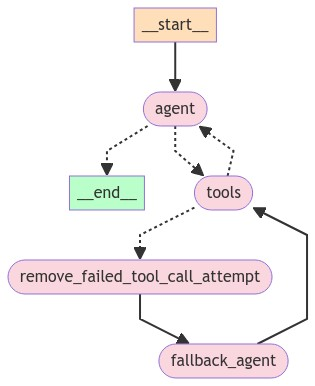

In [7]:
import * as tslab from "tslab";

const graph2 = app2.getGraph();
const image2 = await graph2.drawMermaidPng();
const arrayBuffer2 = await image2.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer2));

Let's try it out. To emphasize the removal steps, let's `stream` the responses from the model so that we can see each executed node:

In [8]:
const stream = await app2.stream(
  { messages: [new HumanMessage("Write me an incredible haiku about water.")] },
  { recursionLimit: 10 },
)

for await (const chunk of stream) {
  console.log(chunk);
}

{
  agent: {
    messages: [
      AIMessage {
        "id": "msg_01GLo6bFLEpcKH1mZHkb2jhf",
        "content": [
          {
            "type": "text",
            "text": "Okay, let's generate a haiku about water using the master haiku generator tool:"
          },
          {
            "type": "tool_use",
            "id": "toolu_01Lyy87dsq6ja6NBZp2P2bLj",
            "name": "master_haiku_generator",
            "input": {
              "topic": "[Array]"
            }
          }
        ],
        "additional_kwargs": {
          "id": "msg_01GLo6bFLEpcKH1mZHkb2jhf",
          "type": "message",
          "role": "assistant",
          "model": "claude-3-haiku-20240307",
          "stop_reason": "tool_use",
          "stop_sequence": null,
          "usage": {
            "input_tokens": 392,
            "output_tokens": 77
          }
        },
        "response_metadata": {
          "id": "msg_01GLo6bFLEpcKH1mZHkb2jhf",
          "model": "claude-3-haiku-20240307",
       

You can see that you get a cleaner response - the more powerful model gets it right on the first try, and the smaller model's failure gets wiped from the graph state. This shorter message history also avoid overpopulating the graph state with attempts.

You can also inspect this [LangSmith trace](https://smith.langchain.com/public/c94f95d0-97fc-4d4d-a59a-b5161c2f4a90/r), which shows the failed initial call to the smaller model.

## Next steps

You've now seen how to implement some strategies to handle tool calling errors.

Next, check out some of the [other LangGraph how-to guides here](/langgraphjs/how-tos/).